In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import display
from functools import partial
import seaborn as sbn

In [2]:
%autoreload
from sarnet_data_utils.data import read_results, summarize, timeout, lookup_row, classify_size
from sarnet_data_utils.integrate import integrate, calc_avg_measurements
from sarnet_data_utils.pandas import color_negative_red
from sarnet_data_utils.plot import plot_attdef as plot_single
pd.options.display.max_columns = 3000 
pd.options.display.max_seq_items = 3000 


In [3]:
%autoreload
thresholds = { 'cpu' : 85, 'sales' :200, 'logfail': 20}

data_120 = read_results('paperlatest', thresholds)
data_60 = data_120[data_120['Recover'] < 60]
data_90 = data_120[data_120['Recover'] < 90]

sum_60 = summarize(data_120, filter_failed=False, filter_nd=True, timeout=60)
sum_90 = summarize(data_120, filter_failed=False, filter_nd=True, timeout=90)
sum_120 = summarize(data_120, filter_failed=False, filter_nd=True)

## Fig.9 Successful run one Threshold (DDoS)

In [4]:
plt.rc('legend',**{'fontsize':20})
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.rc('axes', labelsize=20) 
th = {k: v for k, v in thresholds.items() if k in ['sales']}
plot_single('udp_20M_w10_dudp-rateup_r0', data_60, run=10, thresholds=th);
plt.savefig('../plot_udp-success.eps', format='eps')

## fig.10 failed run one threshold (PWD)

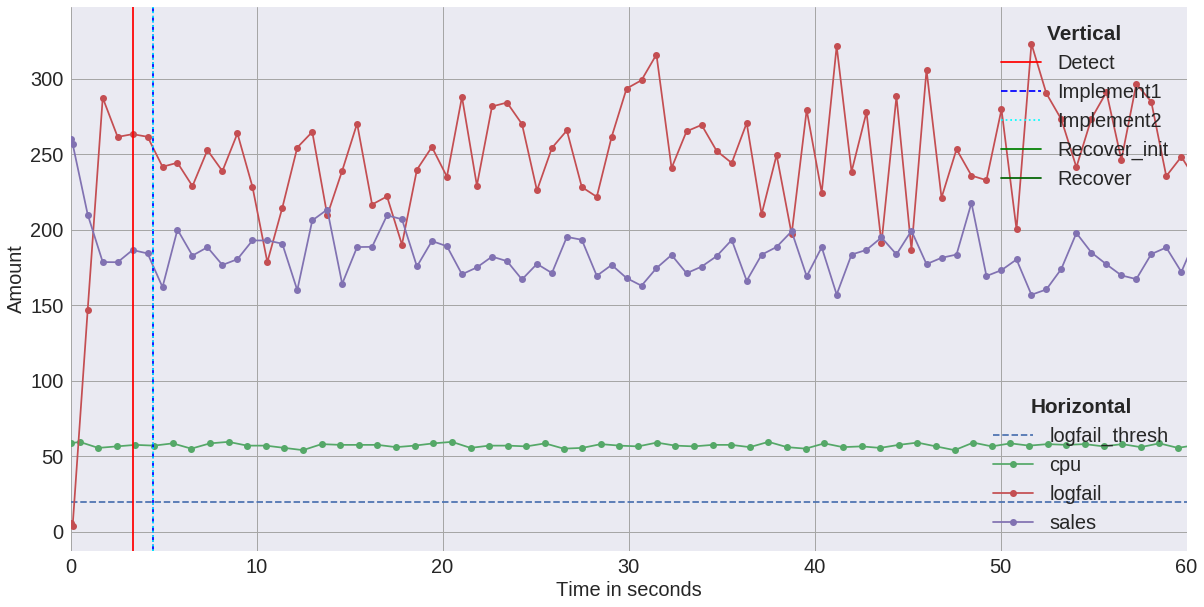

In [5]:
th = {k: v for k, v in thresholds.items() if k in ['logfail']}
plot_single('pwd_5_w10_dudp-filter_r0', data_60, run=1, thresholds=th);
plt.savefig('../plot_pwd-fail.eps', format='eps')

## fig.11 failed run one threshold recovered one failed (CPU)

**TODO: Current results are broken**

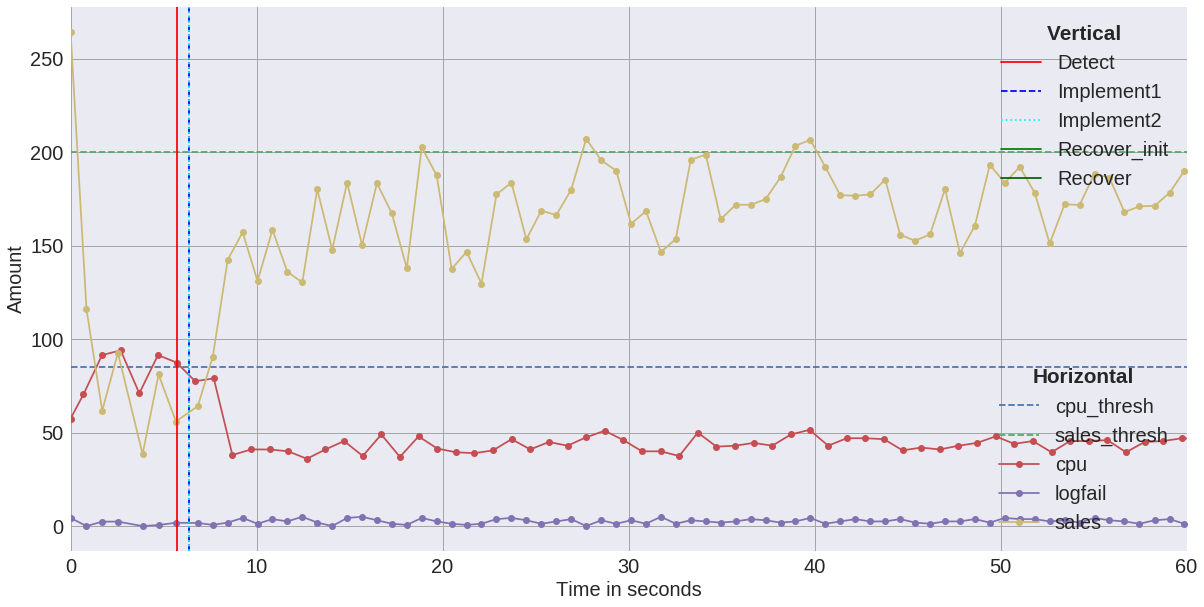

In [6]:
th = {k: v for k, v in thresholds.items() if k in ['sales', 'cpu']}
plot_single('cpu_15_w10_dcaptcha_r0', data_60, run=1, thresholds=th);
plt.savefig('../plot_cpu_fail_x1.eps', format='eps')

## fig.12 failed run 2 tresholds (CPU)

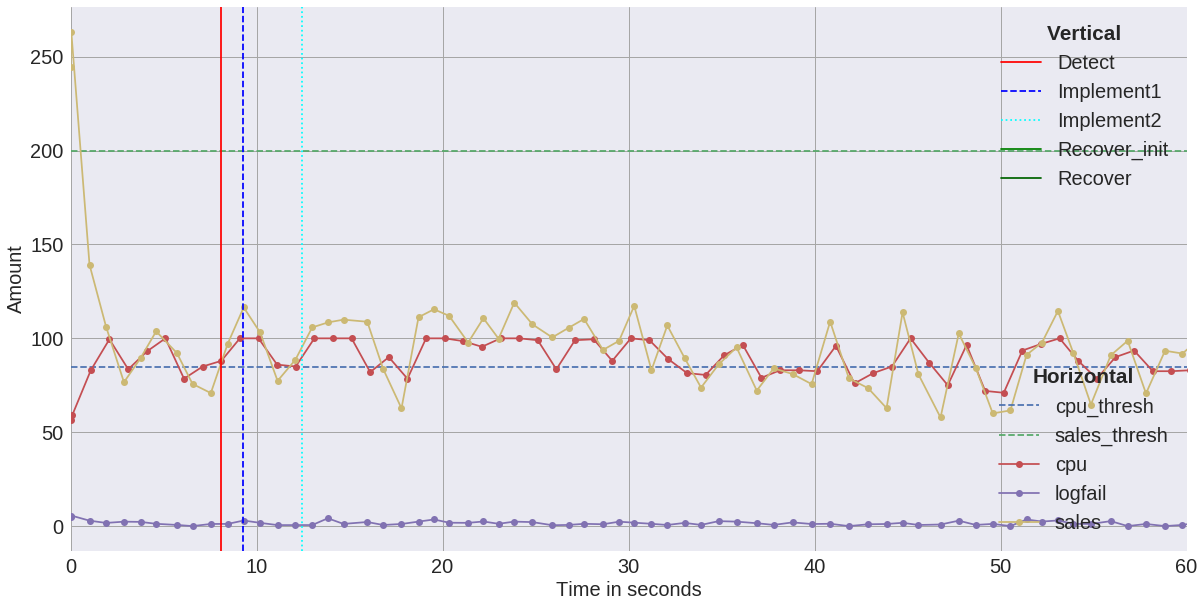

In [93]:
th = {k: v for k, v in thresholds.items() if k in ['sales', 'cpu']}
plot_single('cpu_10_w10_dudp-rateup_r0', data_60, run=3, thresholds = th);
plt.savefig('../plot_cpu_fail_x2.eps', format='eps')

## Table 1: Recovery success ratio

In [78]:
df2 = sum_60.xs(key='0', level ='Relax')
df2 = classify_size(df2)
#df2 = df2.pivot_table(['detected','success'], ['Attack', 'Defence'], 'Size')
df2 = df2.pivot_table(['success'], ['Attack', 'Defence'], 'Size')


#presentation stuf.
df2 = df2.round(1)
#df2 = df2[~df2.isin([0, None]).all(1)] #remove lines with 0 or fail
df2 = df2.reindex(columns=['Light', 'Medium', 'Heavy'], level=1)
df2.index.name = 'Attack/Defence' 
df2.rename(columns={'success':'% attacks recovered'}, inplace=True)
#df2.rename(columns={'detected':'% attacks detected'}, inplace=True)
with open('../tbl_success_size.tex', 'w') as out:
    out.write(df2.to_latex(bold_rows=True))
df2

% attacks recovered              
Size                            Light Medium  Heavy
Attack Defence                                     
cpu    captcha                   33.3   13.3    6.7
       honeypot                  73.3   86.7   76.7
       udp-filter                 0.0    0.0    0.0
       udp-rateup                 0.0    0.0    0.0
pwd    captcha                  100.0  100.0  100.0
       honeypot                 100.0  100.0  100.0
       udp-filter                 0.0    0.0    0.0
       udp-rateup                 0.0    0.0    0.0
udp    captcha                    3.3    0.0    0.0
       honeypot                 100.0    0.0    0.0
       udp-filter                96.7   96.7  100.0
       udp-rateup               100.0    0.0    0.0

## Table 2: Recovery time

In [95]:
df = classify_size(sum_120)
df['rectime'] = df['Recover'] - df['Detect']

df = df.pivot_table(['rectime'], ['Attack', 'Defence','Relax'], 'Size')

df = df.xs(key='0', level ='Relax')
df = df.dropna(how='all')
df = df.fillna('fail').round(1)

df = df.reindex(columns= ['Light', 'Medium', 'Heavy'], level=1)
df.columns.names=[' ', 'Attack Size']

with open('../tbl_recover.tex', 'w') as out:
    out.write(df.to_latex(bold_rows=True, multirow=True))

df


rectime                  
Attack Size         Light   Medium    Heavy
Attack Defence                             
cpu    captcha       64.8  58.0487  41.5699
       honeypot      43.4  40.8485  41.3457
pwd    captcha       11.4   11.418  11.5727
       honeypot      11.6  11.5904  11.9039
udp    captcha        1.9     fail     fail
       honeypot      14.8     fail     fail
       udp-filter    16.5  20.6884  18.5436
       udp-rateup    17.4     fail     fail

## Table 3 Effectiveness 

In [92]:
df = data_60.copy() #make sure we don't use the main data set
df = df[df['Recover'] < 60] #this makes sure that we only calculate integral over Recovery whithin 60s 
df = summarize(df, filter_failed=False, filter_nd=True, timeout=60) 

df = classify_size(df)
df = df[df['success'] > 0]
df = df[df['Relax'] == '0']
df = df.pivot_table(['Integral'], ['Attack', 'Defence', 'Type'], 'Size')
df = df.sort_index()
df = df.dropna(how='all', axis=0)
df.columns.names=[' ', 'Attack Size']
df = df.reindex(columns= ['Light', 'Medium', 'Heavy'], level=1)
#df = df[(df != 0).any(1)] #remove 0
df = df.round(3)
df = df[~df.isin([0, None]).all(1)] #remove lines with 0 or fail
df.rename(columns={'Integral':'Impact'}, inplace=True)
df = df.fillna('fail')

with open('../tbl_effectiveness.tex', 'w') as out:
    out.write(df.to_latex(bold_rows=True, multirow=False, index=True, sparsify=False))

df

Impact              
Attack Size                Light Medium  Heavy
Attack Defence    Type                        
cpu    captcha    cpu      0.005  0.005  0.003
                  sales    0.056  0.132  0.167
       honeypot   cpu      0.005  0.005  0.004
                  sales    0.025  0.037  0.056
pwd    captcha    logfail  4.633  6.223  7.325
                  sales    0.061  0.134  0.189
       honeypot   logfail  4.737  6.341  7.336
                  sales    0.039  0.095  0.131
udp    honeypot   sales    0.019   fail   fail
       udp-filter sales    0.000   0.01  0.014
       udp-rateup sales    0.036   fail   fail

## Table 4: Recovery success ratio as time boundries are relaxed (Medium attack)

In [81]:
#with open('../tbl_success_relax.tex', 'w') as out:
#    out.write(df2.to_latex())
gr1 = sum_60[['success', 'Integral', 'e_Integral']]
gr1.columns = ['success_60', 'Integral_60', 'e_Integral_60']

gr2 = sum_90[['success', 'Integral', 'e_Integral']]
gr2.columns = ['success_90', 'Integral_90', 'e_Integral_90']

gr3 = sum_120[['success', 'Integral', 'e_Integral']]
gr3.columns = ['success_120', 'Integral_120', 'e_Integral_120']

merge = gr1.join([gr2, gr3], how='outer').fillna(0).round(1)
merge = classify_size(merge)
merge.set_index(['Attack','Size','Defence', 'Relax', 'Type'], inplace=True)

merge = merge[['success_60', 'success_90', 'success_120']]
#display(merge)


    
merge = merge.xs(level=['Relax', 'Type'], key = ['0', 'sales'])
merge = merge.xs(level='Size', key='Medium', drop_level=True)
merge = merge[(merge != 0).any(1)] #remove 0

merge.columns.name='Relax timeout by:'
merge.columns = ['0% (60s)', '150% (90s)', '200% (120s)']

with open('../tbl_success_timeout.tex', 'w') as out:
    out.write(merge.to_latex(bold_rows=True, multirow=True))
merge


0% (60s)  150% (90s)  200% (120s)
Attack Defence                                      
cpu    captcha         13.3        23.3         26.7
       honeypot        86.7        96.7        100.0
pwd    captcha        100.0       100.0        100.0
       honeypot       100.0       100.0        100.0
udp    udp-filter      96.7       100.0        100.0

## Table 5: Recovery success ratio as thresholds are relaxed (Medium attack)

In [82]:
#data selection
df2 = classify_size(sum_60)
df2 = df2.pivot_table('success', ['Attack', 'Size', 'Defence'], 'Relax')
df2 = df2[['0', '5', '10', '15']]
df2 = df2.xs(level='Size', key='Medium', drop_level=True)

#presentation stuff
df2 = df2[(df2 != 0).any(1)] #remove all 0 lines 
df2 = df2.round(1)
df2.index.name = 'Attack/Defence' 
df2.columns.name = 'Relax threshold by ' 
df2.columns = ['0%', '5%', '10%', '15%']

with open('../tbl_success_relax.tex', 'w') as out:
    out.write(df2.to_latex(bold_rows=True, multirow=True))
df2

0%     5%    10%    15%
Attack Defence                               
cpu    captcha      13.3   36.7   40.0   36.7
       honeypot     86.7   63.3   86.7   73.3
pwd    captcha     100.0  100.0  100.0  100.0
       honeypot    100.0  100.0  100.0  100.0
udp    udp-filter   96.7  100.0  100.0  100.0

## Figure 13: False response

In [83]:
#example of why 'honeypot' works on ddos attack. #relax makes this worse
th = {k: v for k, v in thresholds.items() if k in ['sales', 'cpu']}
plot_single('udp_20M_w10_dhoneypot_r0', data_60, run=3, thresholds=th);
plt.savefig('../plot_defence_noop_udp-honey.eps', format='eps')


## Oddities and things to explain

In [84]:
df = sum_120.xs(['cpu', 'honeypot', '15'], level=['Attack', 'Defence', 'Relax'])
display(df)

AttDef      Mean_x   Index    Detect  \
Size Type                                                              
10   cpu      cpu_10_w10_dhoneypot_r15   54.861667  2714.5  6.554520   
     logfail  cpu_10_w10_dhoneypot_r15    3.367257  2714.5  6.554520   
     sales    cpu_10_w10_dhoneypot_r15  228.251103  2714.5  6.554520   
15   cpu      cpu_15_w10_dhoneypot_r15   54.186667  2754.5  6.487603   
     logfail  cpu_15_w10_dhoneypot_r15    3.526684  2754.5  6.487603   
     sales    cpu_15_w10_dhoneypot_r15  222.963465  2754.5  6.487603   
5    cpu       cpu_5_w10_dhoneypot_r15   55.800000  2674.5  6.865057   
     logfail   cpu_5_w10_dhoneypot_r15    3.534519  2674.5  6.865057   
     sales     cpu_5_w10_dhoneypot_r15  235.787062  2674.5  6.865057   

              Implement1  Implement2    Recover  Recover_init      Mean_y  \
Size Type                                                                   
10   cpu        7.265466    7.265780  51.120622     41.766168  228.251103   
     logfail    7.265466    7.265780  51.120622     41.766168  228.251103   
     sales      7.265466    7.265780  51.120622     41.766168  228.251103   
15   cpu        7.263369    7.263677  56.125271     46.873877  222.963465   
     logfail    7.263369    7.263677  56.125271     46.873877  222.963465   
     sales      7.263369    7.263677  56.125271     46.873877  222.963465   
5    cpu        7.593594    7.593909  54.502515     45.194342  235.787062   
     logfail    7.593594    7.593909  54.502515     45.194342  235.787062   
     sales      7.593594    7.593909  54.502515     45.194342  235.787062   

              d_detect_i1   d_i1_i2  d_i2_recover  d_recinit_recover  \
Size Type                                                              
10   cpu         0.710946  0.000313     34.500389           9.354454   
     logfail     0.710946  0.000313     34.500389           9.354454   
     sales       0.710946  0.000313     34.500389           9.354454   
15   cpu         0.775766  0.000308     39.610200           9.251394   
     logfail     0.775766  0.000308     39.610200           9.251394   
     sales       0.775766  0.000308     39.610200           9.251394   
5    cpu         0.728538  0.000314     37.600434           9.308173   
     logfail     0.728538  0.000314     37.600434           9.308173   
     sales       0.728538  0.000314     37.600434           9.308173   

              Integral  e_Detect  e_Implement1  e_Implement2     e_Index  \
Size Type                                                                  
10   cpu      0.003236  0.302863      0.306322      0.306320  218.332888   
     logfail  0.000000  0.302863      0.306322      0.306320  218.332888   
     sales    0.027975  0.302863      0.306322      0.306320  218.332888   
15   cpu      0.004377  0.285242      0.294479      0.294479  218.332888   
     logfail  0.000000  0.285242      0.294479      0.294479  218.332888   
     sales    0.039112  0.285242      0.294479      0.294479  218.332888   
5    cpu      0.004194  0.352649      0.355036      0.355036  218.332888   
     logfail  0.000000  0.352649      0.355036      0.355036  218.332888   
     sales    0.015351  0.352649      0.355036      0.355036  218.332888   

              e_Integral  e_Mean_x  e_Mean_y  e_Recover  e_Recover_init  \
Size Type                                                                 
10   cpu        0.000413  0.245929  0.759169   2.328713        2.333612   
     logfail    0.000000  0.087806  0.759169   2.328713        2.333612   
     sales      0.001786  0.759169  0.759169   2.328713        2.333612   
15   cpu        0.000755  0.214569  0.644462   4.012600        4.013103   
     logfail    0.000000  0.085372  0.644462   4.012600        4.013103   
     sales      0.003872  0.644462  0.644462   4.012600        4.013103   
5    cpu        0.000678  0.238192  0.818199   3.738087        3.720225   
     logfail    0.000000  0.085577  0.818199   3.738087        3.720225   
     sales 

In [85]:
#for run in range(0, 30):
#    plot_single('cpu_15_w10_dhoneypot_r10', data_60, run=run, thresholds=th);

In [86]:
from sarnet_data_utils.radar_chart import *

In [87]:
    N = 9
    theta = radar_factory(N, frame='polygon')

    data = example_data() 
    spoke_labels = data.pop(0)

    fig, axes = plt.subplots(figsize=(9, 9), nrows=2, ncols=2,
                             subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    colors = ['b', 'r', 'g', 'm', 'y']
    # Plot the four cases from the example data on separate axes
    for ax, (title, case_data) in zip(axes.flatten(), data):
        ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
        ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                     horizontalalignment='center', verticalalignment='center')
        for d, color in zip(case_data, colors):
            ax.plot(theta, d, color=color)
            ax.fill(theta, d, facecolor=color, alpha=0.25)
        ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    ax = axes[0, 0]
    labels = ('Factor 1', 'Factor 2', 'Factor 3', 'Factor 4', 'Factor 5')
    legend = ax.legend(labels, loc=(0.9, .95),
                       labelspacing=0.1, fontsize='small')

    fig.text(0.5, 0.965, '5-Factor Solution Profiles Across Four Scenarios',
             horizontalalignment='center', color='black', weight='bold',
             size='large')

    plt.show()
